# 프로젝트: CutMix 또는 Mixup 비교실험 하기



데이터셋의 Augmentation을 적용해보는 프로젝트를 진행해보겠다.
> Tensorflow의 Random Augmentation API를 사용하면 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들을 사용할 수 있다.
- [random_brightness()](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness)
- [random_contrast()](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast)
- [random_crop()](https://www.tensorflow.org/api_docs/python/tf/image/random_crop)
- [random_flip_left_right()](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)
- [random_flip_up_down()](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down)
- [random_hue()](https://www.tensorflow.org/api_docs/python/tf/image/random_hue)
- [random_jpeg_quality()](https://www.tensorflow.org/api_docs/python/tf/image/random_jpeg_quality)
- [random_saturation()](https://www.tensorflow.org/api_docs/python/tf/image/random_saturation)


이 프로젝트에서는 최신 심화 기법 [CutMix](https://arxiv.org/pdf/1905.04899.pdf)와 [Mixup](https://arxiv.org/pdf/1710.09412.pdf)을 적용할 예정이다.<br>
 [Stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) 데이터셋을 이용하여 
Augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능을 비교하는 실험을 진행해보겠다.

#### ✔︎ 라이브러리 setting

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 1. Augmentation을 적용한 데이터셋 만들기
### 1) 데이터 불러오기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='/content/drive/MyDrive/AIFFEL/GoingDeeper/GD3,4/Dataset')


In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

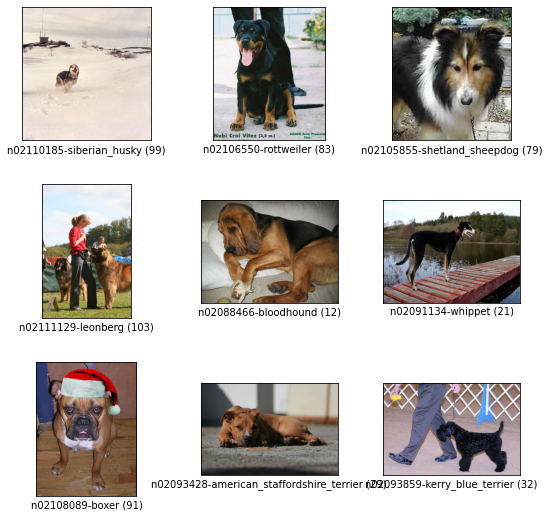

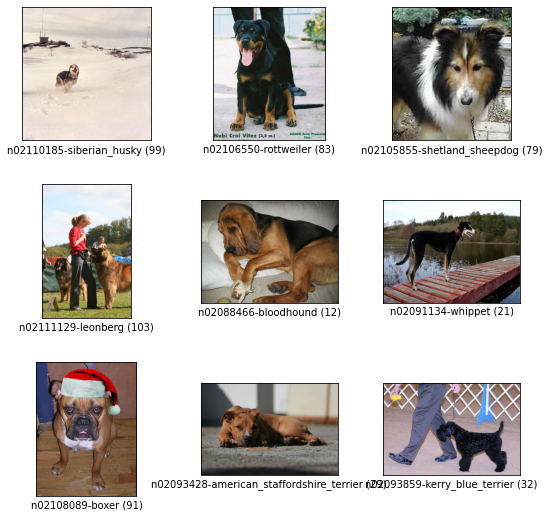

In [ ]:
# 데이터셋 확인
tfds.show_examples(ds_train, ds_info)

### 2) 기본 전처리 함수 정의

In [ ]:
# Image Normalization & Resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 랜덤 좌우 반전 & 밝기 조절
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# One-hot encoding
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### 3) CutMix 함수 정의

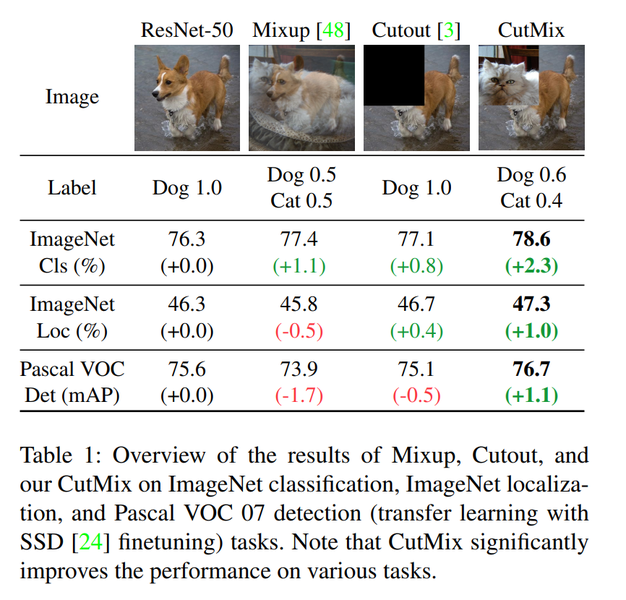

In [ ]:
# 바탕이미지 a, 삽입할 이미지 b가 있을 때 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 삽입할 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# 두 이미지가 섞인 면적의 비율에 비례하여 라벨의 비율을 섞어주는 함수
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
# CutMix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4) Mixup 함수 정의

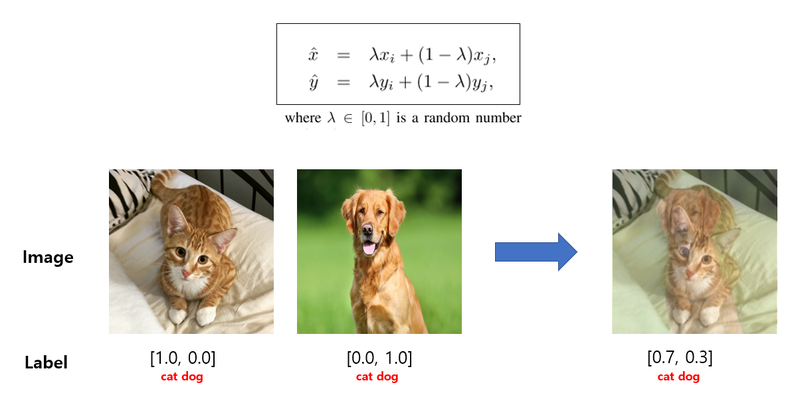

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
# Batch 단위의 Mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 5) 전체 Dataset에 적용할 함수 정의

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):

    ds = ds.map(normalize_and_resize_img, 
                num_parallel_calls=2)
    
    # 기본 augmentation
    if not is_test and with_aug:
        ds = ds.map(augment)

    # CutMix와 Mixup 앞에 batch 함수가 나와야 미리 배치 단위로 데이터셋을 정렬 후 Augmentation들을 적용 가능
    ds = ds.batch(batch_size)

    # CutMix
    if not is_test and with_cutmix:
        ds = ds.map(cutmix,
                    num_parallel_calls=2)

    # Mixup    
    elif not is_test and with_mixup:
        ds = ds.map(mixup,
                    num_parallel_calls=2)
    
    # test 데이터셋에 대해 One-Hot 벡터 형태로 변환시켜줌
    else:
        ds = ds.map(onehot,
                    num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### 6) Dataset에 적용

In [ ]:
# Augmentation 적용 X, 기본 전처리
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 기본 Augmentation 적용
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# CutMix 적용
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)

# Mixup 적용
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

# Test set 전처리
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

---
## 2. 모델 만들기
ResNet-50을 사용하여 비교 실험을 위한 모델을 만들어보겠다.
<br> ImageNet 데이터를 학습시킨 모델을 불러올 것이다.
<br>Augmentation을 적용하지 않은 데이터셋을 넣을 모델, 기본 Augmentation만 적용한 데이터셋을 넣을 모델, CutMix를 적용한 데이터셋을 넣을 모델, Mixup을 적용한 데이터셋을 넣을 모델 이렇게 네 가지를 만들 예정이다.

In [ ]:
# Augmentation을 적용하지 않은 데이터셋을 넣을 모델

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,     # 기존의 Fully-connected layer 제외
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),

    keras.layers.Dense(num_classes, activation='softmax')  # num_classes에 맞는 FC layer 추가
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# 기본 Augmentation만 적용한 데이터셋을 넣을 모델

resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# CutMix를 적용한 데이터셋을 넣을 모델

resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# Mixup을 적용한 데이터셋을 넣을 모델

resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

---
## 3. 모델 훈련하기

cutmix(), mixup()을 구현하면셔 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었으므로, sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용할 예정이다.

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [ ]:
# Augmentation을 적용하지 않은 데이터셋 넣고 모델 학습

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 115s 126ms/step - loss: 2.1781 - accuracy: 0.4559 - val_loss: 3.1679 - val_accuracy: 0.2449
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.6850 - accuracy: 0.8138 - val_loss: 1.1320 - val_accuracy: 0.6721
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1827 - accuracy: 0.9675 - val_loss: 0.9100 - val_accuracy: 0.7299
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0475 - accuracy: 0.9969 - val_loss: 0.9095 - val_accuracy: 0.7392
Epoch 5/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0202 - accuracy: 0.9997 - val_loss: 0.9160 - val_accuracy: 0.7415
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0130 - accuracy: 0.9999 - val_loss: 0.9292 - val_accuracy: 0.7392
Epoch 7/20
750/750 [==============================] - 95s 127ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.9415 - val_accuracy: 0.

In [ ]:
# 기본 Augmentation만 적용한 데이터셋을 넣고 모델 학습

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 100s 122ms/step - loss: 2.2675 - accuracy: 0.4303 - val_loss: 3.0462 - val_accuracy: 0.2656
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 0.9614 - accuracy: 0.7225 - val_loss: 1.3748 - val_accuracy: 0.6074
Epoch 3/20
750/750 [==============================] - 95s 126ms/step - loss: 0.5685 - accuracy: 0.8405 - val_loss: 1.2958 - val_accuracy: 0.6300
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.3489 - accuracy: 0.9038 - val_loss: 1.0375 - val_accuracy: 0.7000
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1925 - accuracy: 0.9565 - val_loss: 1.0670 - val_accuracy: 0.7041
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 0.1027 - accuracy: 0.9814 - val_loss: 0.9893 - val_accuracy: 0.7212
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0577 - accuracy: 0.9921 - val_loss: 0.9479 - val_accuracy: 0.

In [ ]:
# CutMix를 적용한 데이터셋을 넣고 모델 학습

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 103s 124ms/step - loss: 3.8479 - accuracy: 0.2066 - val_loss: 3.5396 - val_accuracy: 0.1887
Epoch 2/20
750/750 [==============================] - 96s 128ms/step - loss: 2.9509 - accuracy: 0.4329 - val_loss: 1.4368 - val_accuracy: 0.6069
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 2.5945 - accuracy: 0.5468 - val_loss: 1.2754 - val_accuracy: 0.6414
Epoch 4/20
750/750 [==============================] - 96s 128ms/step - loss: 2.4254 - accuracy: 0.5953 - val_loss: 1.2034 - val_accuracy: 0.6652
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 2.2526 - accuracy: 0.6628 - val_loss: 1.1377 - val_accuracy: 0.6872
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 2.1357 - accuracy: 0.6983 - val_loss: 1.4292 - val_accuracy: 0.6195
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.0369 - accuracy: 0.7210 - val_loss: 1.1918 - val_a

In [ ]:
# Mixup을 적용한 데이터셋을 넣고 모델 학습

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 106s 129ms/step - loss: 3.7089 - accuracy: 0.2472 - val_loss: 3.7391 - val_accuracy: 0.1585
Epoch 2/20
750/750 [==============================] - 92s 123ms/step - loss: 2.8302 - accuracy: 0.4870 - val_loss: 1.3457 - val_accuracy: 0.6188
Epoch 3/20
750/750 [==============================] - 92s 123ms/step - loss: 2.5669 - accuracy: 0.5861 - val_loss: 1.3533 - val_accuracy: 0.6136
Epoch 4/20
750/750 [==============================] - 96s 128ms/step - loss: 2.3984 - accuracy: 0.6524 - val_loss: 1.2676 - val_accuracy: 0.6530
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2678 - accuracy: 0.7018 - val_loss: 1.3591 - val_accuracy: 0.6357
Epoch 6/20
750/750 [==============================] - 96s 128ms/step - loss: 2.1729 - accuracy: 0.7387 - val_loss: 1.2249 - val_accuracy: 0.6686
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.0943 - accuracy: 0.7663 - val_loss: 1.2713 - val_accuracy: 0.

---
## 4. 훈련 과정 시각화하기

#### 1) Val accuracy

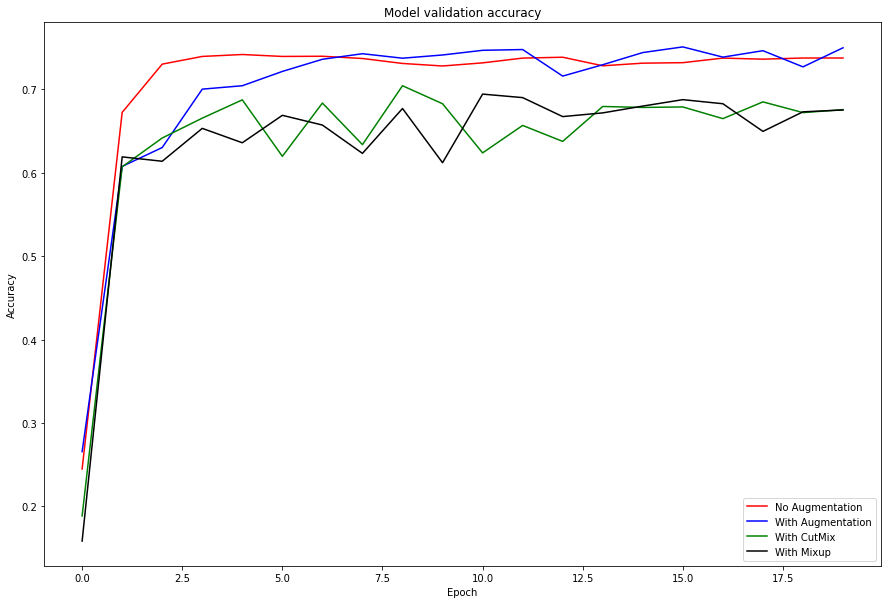

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.show()

#### 2) Val loss

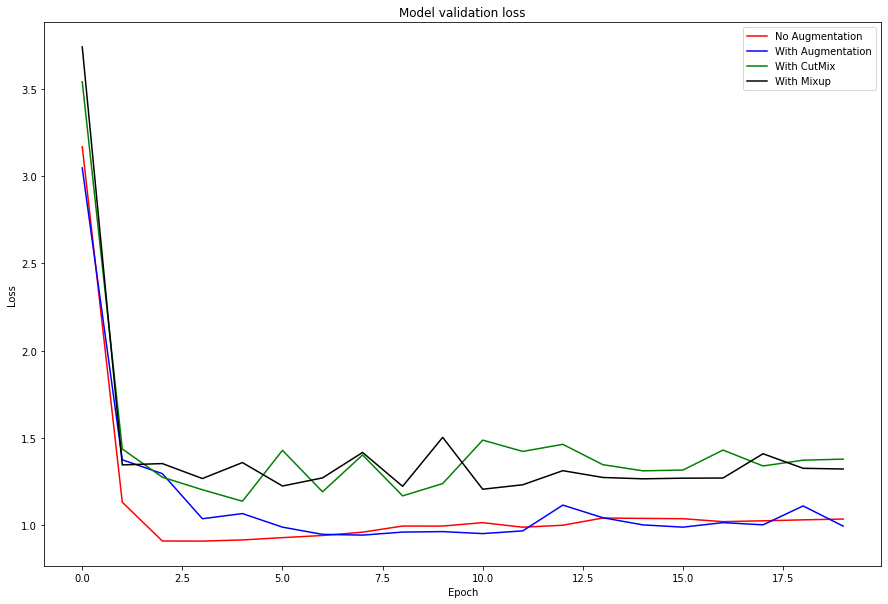

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.show()

---
## 5. 결과 분석 및 회고

우선 Augmentation을 적용하지 않은 경우와 기본 Augmentation만 적용한 경우 둘을 비교해보자면 적용한 경우의 성능이 미세하게 조금 더 좋은 것 같다. 그러나 CutMix와 Mixup까지 적용한 경우들은 결과가 처참했다. 오히려 적용하지 않은 경우가 훨씬 낫다.

사실 이전에도 Augmentation을 사용해본 적이 있다. 데이터가 많이 부족한 분야인 의료계의 대표적인 데이터셋인 폐렴 X-ray 사진을 가지고 Augmentation을 진행했었는데, 그때도 느낀 것은 애매한 학습과정과 애매한 데이터셋으로 실험을 하게 된다면 오히려 모델이 더 혼란을 느껴 학습 정확도가 떨어지고 제대로 학습이 되지 않는다는 것을 느꼈다. 그렇다면 제일 먼저 생각해볼 것은 모델이 혼란을 느끼지 않게 정제된 것들만 넣어줘야 한다는 생각이다. 그러나 실생활에서 우리가 이것들을 적용할 때에는 그렇게 단순한 방법으로는 해결이 되지 않는다. 세상에는 raw한 데이터들이 굉장히 많고 그것들을 다 구분하거나 이용해야하는 상황에서, 앞으로 더 계속 공부하고 연구해서 혼란을 느끼는 부분까지 생각을 하고 보완을 해주어야 할 필요가 있다. 그래서 더 발전된 형태의 Augmentation 기법들이 필요하고, 여러 다른 기법들을 조합해서 최적의 효과를 발생시키는 방법을 강구해내야 할 것이다.

다음에 복습할 때는 앞의 이론 파트에서 봤던 Albumentation 라이브러리와, 다양한 기법들을 다시 적용하여 훈련시켜 봐야겠다.